### **STAKEHOLDERS** - Healthcare Professionals
### **BUSINESS QUESTION** - Who is likely to seek mental health treatment?
### **TARGET VARIABLE** - Treatment (Treatment is a highly balanced class, yes and no are uniformly distributed)
### **FEATURES** - Gender,	Country	Occupation,	self_employed,	family_history, Days_Indoors,	Growing_Stress,	Changes_Habits,	Mental_Health_History,	Mood_Swings,	Coping_Struggles,	Work_Interest,	Social_Weakness,mental_health_interview,	care_options

### **1. Load Libraries**
### **2. Load and Preprocess Data**
*  Import mental health dataset  from Kaggle using Spark.
*  Handle nulls, duplicates, drop Timestamp.
*  Group rare countries into "Other".

### **3. Exploratory Data Analysis**



# **1. Import Libraries**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier, Pool
from scipy.stats import chi2_contingency
import pickle


# **2. Load and Preprocess Data**

In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, col, sum, count, when

# Set Spark version and Java environment variables
spark_version = 'spark-3.5.5'
os.environ['SPARK_VERSION']=spark_version
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,140 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,246 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packag

In [ ]:
import time
# Create a SparkSession
spark = SparkSession.builder.appName("Mental Health Analysis").getOrCreate()
from google.colab import files
files.upload()  # Upload kaggle.json here
# Move to hidden kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

# Install Kaggle CLI if not already installed
!pip install -q kaggle

# Download your dataset (e.g., the NIH Chest X-rays sample dataset)
!kaggle datasets download -d divaniazzahra/mental-health-dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/divaniazzahra/mental-health-dataset
License(s): MIT


In [ ]:
import zipfile

with zipfile.ZipFile("mental-health-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("mental_health_dataset")


# Read the csv file and display the schema

In [ ]:
# Read csv
csv_path = "mental_health_dataset/Mental Health Dataset.csv"
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# **Data Preprocessing**

# **Convert Spark Dataframe to Pandas DataFrame**

In [ ]:
mental_health = df.toPandas()
mental_health.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,2014-08-27 11:29:31,Female,United States,Corporate,None,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,2014-08-27 11:31:50,Female,United States,Corporate,None,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,2014-08-27 11:32:39,Female,United States,Corporate,None,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,2014-08-27 11:37:59,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,2014-08-27 11:43:36,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


# **Extraction Transformation and Loading**
### 1. Check for datatypes, number of rows, columns
### 2. Check for columns with null rows.
### 3. Fill missing values with the most frequent value in that column using impute.
### 4. Check for duplicated rows and drop duplicate rows.
### 5. Drop Timestamp column.
### 6. Replace rare countries (Country.value_counts<1000) with Other


In [ ]:
# Copy for preprocessing
mental_health_df = mental_health.copy()
mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Timestamp                292364 non-null  datetime64[ns]
 1   Gender                   292364 non-null  object        
 2   Country                  292364 non-null  object        
 3   Occupation               292364 non-null  object        
 4   self_employed            287162 non-null  object        
 5   family_history           292364 non-null  object        
 6   treatment                292364 non-null  object        
 7   Days_Indoors             292364 non-null  object        
 8   Growing_Stress           292364 non-null  object        
 9   Changes_Habits           292364 non-null  object        
 10  Mental_Health_History    292364 non-null  object        
 11  Mood_Swings              292364 non-null  object        
 12  Coping_Struggles

In [ ]:
# # Assuming your DataFrame is called 'mental_health_df' and the timestamp column is called 'Timestamp'
# import pandas as pd

# # 1. Convert the 'Timestamp' column to datetime objects
# mental_health_df['Timestamp'] = pd.to_datetime(mental_health_df['Timestamp'])

# # 2. Create a new column with month-year combination
# mental_health_df['Month_Year'] = mental_health_df['Timestamp'].dt.to_period('M')


# # 3. Get unique months-year  combination
# unique_months_years = mental_health_df['Month_Year'].unique()


# # 4. Print the results
# print("Unique Month-Year Combination:", unique_months_years)


* 2014 - Aug, Sept, Oct, Nov, Dec
* 2015 - Feb, April, May, June, July, Aug, Sept
* 2016 - Feb

In [ ]:
# Check for nulls
mental_health_df.isnull().sum()

,0
Timestamp,0
Gender,0
Country,0
Occupation,0
self_employed,5202
family_history,0
treatment,0
Days_Indoors,0
Growing_Stress,0
Changes_Habits,0


In [ ]:
# Drop nulls
mental_health_df.dropna(inplace=True)

In [ ]:
# Verify nulls are dropped
mental_health_df.isnull().sum()

,0
Timestamp,0
Gender,0
Country,0
Occupation,0
self_employed,0
family_history,0
treatment,0
Days_Indoors,0
Growing_Stress,0
Changes_Habits,0


In [ ]:
# Drop duplicates
mental_health_df_cleaned=mental_health_df.drop_duplicates()

In [ ]:
# Drop Timestamp
mental_health_df_cleaned.drop('Timestamp', axis=1, inplace=True)

<ipython-input-14-51b438defb92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned.drop('Timestamp', axis=1, inplace=True)


In [ ]:
# Group rare countries (< 1000 counts) into "Other"
# Number of distinct countries
distinct_country_count = mental_health_df_cleaned['Country'].nunique()
print(f"Number of distinct countries: {distinct_country_count}")

# Count of rows per country, sorted
country_counts = mental_health_df_cleaned['Country'].value_counts()

# Filter countries with at least 1000 entries
popular_countries = country_counts[country_counts >= 1000].index.tolist()

# Replace less frequent countries with 'Other'
mental_health_df_cleaned['Country'] = mental_health_df_cleaned['Country'].apply(lambda x: x if x in popular_countries else 'Other')
mental_health_df_cleaned['Country'].value_counts()

Number of distinct countries: 35


<ipython-input-15-d6103a1f763a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned['Country'] = mental_health_df_cleaned['Country'].apply(lambda x: x if x in popular_countries else 'Other')


,count
Country,
United States,167819
United Kingdom,50576
Canada,17529
Other,9832
Australia,6014
Netherlands,5891
Ireland,5542
Germany,4680
Sweden,2812


In [ ]:
  # Count the total number of rows
print(f"Total number of rows before preprocessing: {mental_health.shape}")
print(f"Total number of rows after preprocessing: {mental_health_df_cleaned.shape}")
print(f"Cleaned DataFrame:")
mental_health_df_cleaned.head()


Total number of rows before preprocessing: (292364, 17)
Total number of rows after preprocessing: (286808, 16)
Cleaned DataFrame:


,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
3,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
5,Female,Other,Corporate,No,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Not sure
6,Female,Australia,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
7,Female,United States,Corporate,No,No,No,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No


# **Exploratory Data Analysis (EDA)**

In [ ]:
# Basic Stats
print("\nData Info:")
mental_health_df_cleaned.reset_index().info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286808 entries, 0 to 286807
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   index                    286808 non-null  int64 
 1   Gender                   286808 non-null  object
 2   Country                  286808 non-null  object
 3   Occupation               286808 non-null  object
 4   self_employed            286808 non-null  object
 5   family_history           286808 non-null  object
 6   treatment                286808 non-null  object
 7   Days_Indoors             286808 non-null  object
 8   Growing_Stress           286808 non-null  object
 9   Changes_Habits           286808 non-null  object
 10  Mental_Health_History    286808 non-null  object
 11  Mood_Swings              286808 non-null  object
 12  Coping_Struggles         286808 non-null  object
 13  Work_Interest            286808 non-null  object
 14  Social_W

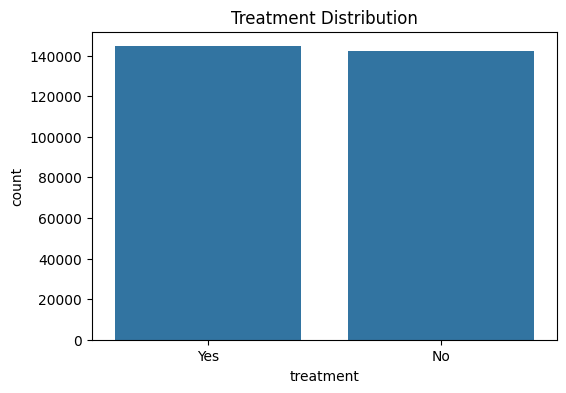

In [ ]:
# Target Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='treatment', data = mental_health_df_cleaned)
plt.title('Treatment Distribution')
plt.show()

#### Analyses - There is no imbalance in class(Yes/No) distribution. Therefore, treatment can be used as a target variable.

# **Modeling using CATBOOST Algorithm**

In [ ]:
# Initial Model for Feature Importance
X =mental_health_df_cleaned.drop('treatment', axis =1)
y = mental_health_df_cleaned['treatment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0)
cat_features = X.columns.to_list()
train_pool = Pool(X_train, y_train, cat_features = cat_features)
test_pool = Pool(X_test, y_test, cat_features = cat_features)

In [ ]:
# Train initial Catboost model
initial_model = CatBoostClassifier(iterations = 649,# 500
                                   depth = 8, # 6
                                   learning_rate =  0.05, # 0.1
                                   loss_function = 'Logloss',
                                   verbose = 100, # 0, # 100,
                                   random_state =42,
                                   auto_class_weights='Balanced'  # Added
                            )
initial_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100) #50

0:	learn: 0.6724028	test: 0.6721798	best: 0.6721798 (0)	total: 1.33s	remaining: 14m 24s
100:	learn: 0.4269711	test: 0.4225989	best: 0.4225989 (100)	total: 1m 3s	remaining: 5m 45s
200:	learn: 0.4254463	test: 0.4217454	best: 0.4217449 (198)	total: 2m 14s	remaining: 5m
300:	learn: 0.4240802	test: 0.4213037	best: 0.4213037 (300)	total: 3m 28s	remaining: 4m 1s
400:	learn: 0.4225175	test: 0.4209528	best: 0.4209453 (389)	total: 4m 52s	remaining: 3m
500:	learn: 0.4207081	test: 0.4207364	best: 0.4207303 (497)	total: 6m 18s	remaining: 1m 51s
600:	learn: 0.4189675	test: 0.4207006	best: 0.4206925 (595)	total: 7m 42s	remaining: 36.9s
648:	learn: 0.4182199	test: 0.4206923	best: 0.4206923 (648)	total: 8m 23s	remaining: 0us

bestTest = 0.4206922872
bestIteration = 648



In [ ]:
# Predict and evaluate initial model
initial_y_prediction = initial_model.predict(test_pool)
print("\n Initial CatBoost Model performance : ")
print(f"Accuracy : {accuracy_score(y_test,initial_y_prediction)} ")
print(f"Classification Report : \n {classification_report(y_test, initial_y_prediction)}")


 Initial CatBoost Model performance : 
Accuracy : 0.7854502981067606 
Classification Report : 
               precision    recall  f1-score   support

          No       0.82      0.72      0.77     28252
         Yes       0.76      0.84      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.78      0.78     57362
weighted avg       0.79      0.79      0.78     57362



In [ ]:
pickle.dump(initial_model, open('initial_model.pkl', 'wb'))

In [ ]:
# Get feature importance
feature_importance = initial_model.get_feature_importance(prettified=True)
print("\nFeature Importance :")
print(feature_importance)


Feature Importance :
                 Feature Id  Importances
0                   Country    24.932973
1              care_options    23.012225
2            family_history    14.855703
3   mental_health_interview    14.500043
4             self_employed    12.577962
5                    Gender     8.193511
6              Days_Indoors     0.479497
7                Occupation     0.361455
8           Social_Weakness     0.241552
9             Work_Interest     0.207824
10              Mood_Swings     0.198416
11           Growing_Stress     0.167129
12    Mental_Health_History     0.149319
13           Changes_Habits     0.105175
14         Coping_Struggles     0.017215


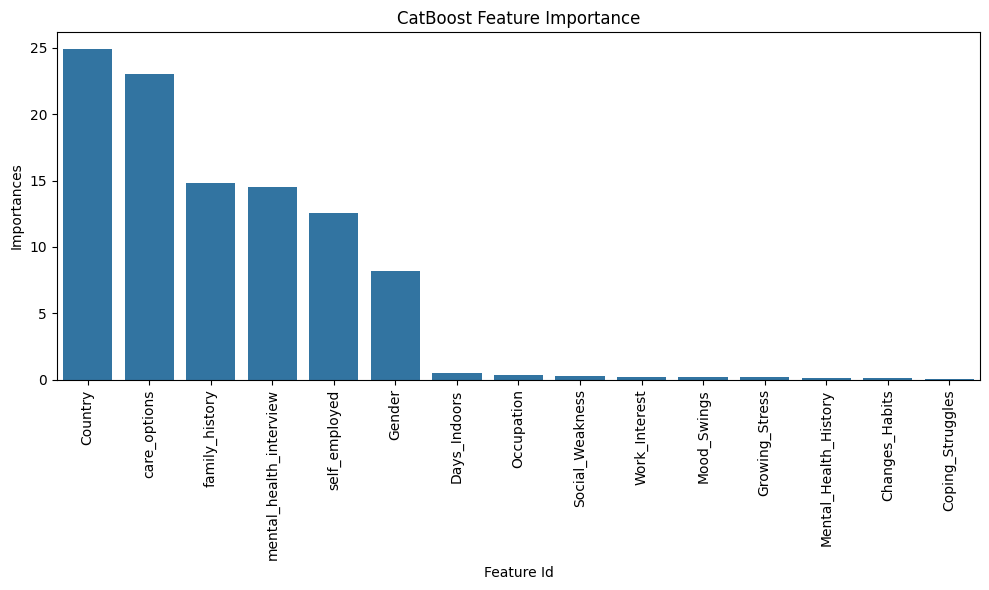

In [ ]:
# Visualizing the feature importance
plt.figure(figsize=(10,6))
sns.barplot(x="Feature Id", y="Importances", data=feature_importance)
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()


Pairwise Cramér’s V Correlation Matrix:
                           Gender   Country  Occupation  self_employed  \
Gender                   0.999988  0.150033    0.049315       0.064985   
Country                  0.150033  1.000000    0.003699       0.236055   
Occupation               0.049315  0.003699    1.000000       0.003206   
self_employed            0.064985  0.236055    0.003206       0.999981   
family_history           0.196321  0.191824    0.009682       0.011195   
Days_Indoors             0.030699  0.002303    0.069072       0.001995   
Growing_Stress           0.056818  0.006028    0.078526       0.003693   
Changes_Habits           0.011585  0.001229    0.065681       0.000753   
Mental_Health_History    0.036368  0.003858    0.074247       0.002364   
Mood_Swings              0.019995  0.002121    0.135105       0.001300   
Coping_Struggles         0.057117  0.008571    0.079852       0.003702   
Work_Interest            0.021950  0.002329    0.057157       0.001427 

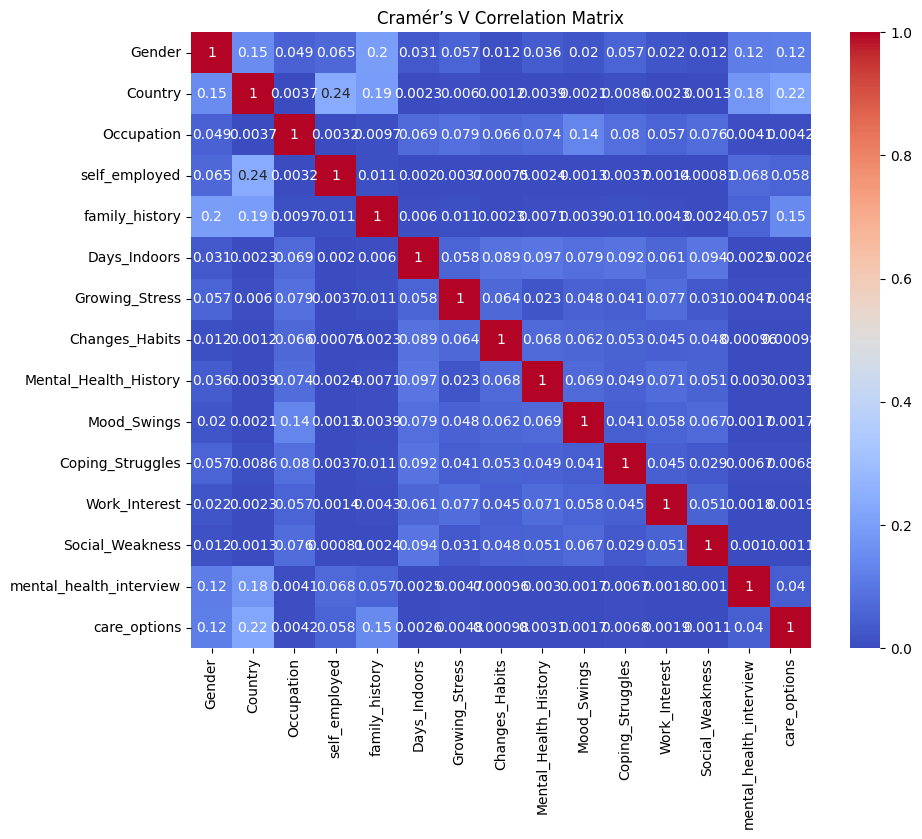


Feature-Target Cramér’s V Correlations:
                         Cramér’s V with Treatment
family_history                            0.371379
care_options                              0.290716
Country                                   0.209506
Gender                                    0.169562
mental_health_interview                   0.101948
self_employed                             0.036731
Coping_Struggles                          0.009680
Growing_Stress                            0.009635
Occupation                                0.008362
Mental_Health_History                     0.006167
Days_Indoors                              0.005206
Work_Interest                             0.003722
Mood_Swings                               0.003391
Social_Weakness                           0.002114
Changes_Habits                            0.001964

Highly Correlated Feature Pairs (Cramér’s V >= 0.3):
[]

Features to Drop due to High Correlation: []


In [ ]:
# 4. Correlation Analysis with Cramér’s V
# Function to calculate Cramér’s V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

# Compute pairwise correlations between features
features = mental_health_df_cleaned.drop('treatment', axis=1).columns
corr_matrix = pd.DataFrame(index=features, columns=features)
for f1 in features:
    for f2 in features:
        corr_matrix.loc[f1, f2] = cramers_v(mental_health_df_cleaned[f1], mental_health_df_cleaned[f2])

corr_matrix = corr_matrix.astype(float)
print("\nPairwise Cramér’s V Correlation Matrix:")
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér’s V Correlation Matrix")
plt.show()

# Compute feature-target correlations
target_corrs = {}
for f in features:
    target_corrs[f] = cramers_v(mental_health_df_cleaned[f], mental_health_df_cleaned['treatment'])
target_corr_df = pd.DataFrame.from_dict(target_corrs, orient='index', columns=['Cramér’s V with Treatment'])
target_corr_df = target_corr_df.sort_values(by='Cramér’s V with Treatment', ascending=False)
print("\nFeature-Target Cramér’s V Correlations:")
print(target_corr_df)

# Identify highly correlated feature pairs (threshold: 0.8)
high_corr_pairs = []
threshold = 0.8
for i in range(len(features)):
    for j in range(i+1, len(features)):
        if corr_matrix.iloc[i, j] >= threshold:
            high_corr_pairs.append((features[i], features[j], corr_matrix.iloc[i, j]))
print("\nHighly Correlated Feature Pairs (Cramér’s V >= 0.3):")
print(high_corr_pairs)

# Drop one feature from each highly correlated pair (if any)
features_to_drop = []
for f1, f2, corr in high_corr_pairs:
    # Keep the feature with higher target correlation
    if target_corrs[f1] > target_corrs[f2]:
        features_to_drop.append(f2)
    else:
        features_to_drop.append(f1)
features_to_drop = list(set(features_to_drop))
print(f"\nFeatures to Drop due to High Correlation: {features_to_drop}")

# Update dataset
if features_to_drop:
    mental_health_df_cleaned = mental_health_df_cleaned.drop(columns=features_to_drop)
    print(f"Dataset Shape after Dropping Correlated Features: {mental_health_df_cleaned.shape}")

# **Optimization 1 - Select Top 6 features**

In [ ]:
top_six_features = feature_importance['Feature Id'].head(6).tolist()
print(f"Selected Top 6 features are : {top_six_features}")

Selected Top 6 features are : ['Country', 'care_options', 'family_history', 'mental_health_interview', 'self_employed', 'Gender']


In [ ]:
mental_data = mental_health_df_cleaned.copy()

In [ ]:
# Filtered dataset
mental_health_df_cleaned_case = mental_health_df_cleaned[top_six_features+['treatment']].reset_index(drop=True)
mental_health_df_cleaned_case.head()

,Country,care_options,family_history,mental_health_interview,self_employed,Gender,treatment
0,United States,Yes,Yes,Maybe,No,Female,Yes
1,United States,Yes,Yes,No,No,Female,Yes
2,Other,Not sure,No,Maybe,No,Female,Yes
3,Australia,Not sure,Yes,No,No,Female,Yes
4,United States,No,No,No,No,Female,No


In [ ]:
# Train test split (with 6 selected features)
X =mental_health_df_cleaned.drop('treatment', axis =1)
y = mental_health_df_cleaned['treatment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0)
# Final model training
cat_features = X.columns.to_list()
train_pool = Pool(X_train, y_train, cat_features = cat_features)
test_pool = Pool(X_test, y_test, cat_features = cat_features)

In [ ]:
# Model training
six_feature_model = CatBoostClassifier(iterations = 649, # 500,
                                   depth = 8, # 6
                                   learning_rate = 0.05,   # 0.1
                                   loss_function = 'Logloss',
                                   verbose = 100, # 0
                                   random_state =42,
                                   auto_class_weights='Balanced'  # Added
                            )
six_feature_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)   # 50

0:	learn: 0.6724028	test: 0.6721798	best: 0.6721798 (0)	total: 786ms	remaining: 8m 29s
100:	learn: 0.4269711	test: 0.4225989	best: 0.4225989 (100)	total: 1m 5s	remaining: 5m 57s
200:	learn: 0.4254463	test: 0.4217454	best: 0.4217449 (198)	total: 2m 24s	remaining: 5m 22s
300:	learn: 0.4240802	test: 0.4213037	best: 0.4213037 (300)	total: 3m 39s	remaining: 4m 14s
400:	learn: 0.4225175	test: 0.4209528	best: 0.4209453 (389)	total: 5m 7s	remaining: 3m 10s
500:	learn: 0.4207081	test: 0.4207364	best: 0.4207303 (497)	total: 6m 32s	remaining: 1m 56s
600:	learn: 0.4189675	test: 0.4207006	best: 0.4206925 (595)	total: 8m 2s	remaining: 38.6s
648:	learn: 0.4182199	test: 0.4206923	best: 0.4206923 (648)	total: 8m 44s	remaining: 0us

bestTest = 0.4206922872
bestIteration = 648



In [ ]:
# Predict and evaluate initial model
y_prediction = six_feature_model.predict(test_pool)
print("\n Initial CatBoost Model performance : ")
print(f"Accuracy : {accuracy_score(y_test,y_prediction)} ")
print(f"Classification Report : \n {classification_report(y_test, y_prediction)}")


 Initial CatBoost Model performance : 
Accuracy : 0.7854502981067606 
Classification Report : 
               precision    recall  f1-score   support

          No       0.82      0.72      0.77     28252
         Yes       0.76      0.84      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.78      0.78     57362
weighted avg       0.79      0.79      0.78     57362



In [ ]:
pickle.dump(six_feature_model, open('six_feature_model.pkl', 'wb'))

# **Optimization 2 - Select Top 10 Features**


In [ ]:
top_ten_features = feature_importance['Feature Id'].head(10).tolist()
print(f"Selected Top 10 features are : {top_ten_features}")
# Filtered dataset
mental_health_df_cleaned_casetwo = mental_health_df_cleaned[top_ten_features+['treatment']]
mental_health_df_cleaned_casetwo.head()

Selected Top 10 features are : ['Country', 'care_options', 'family_history', 'mental_health_interview', 'self_employed', 'Gender', 'Days_Indoors', 'Occupation', 'Social_Weakness', 'Work_Interest']


,Country,care_options,family_history,mental_health_interview,self_employed,Gender,Days_Indoors,Occupation,Social_Weakness,Work_Interest,treatment
3,United States,Yes,Yes,Maybe,No,Female,1-14 days,Corporate,Yes,No,Yes
4,United States,Yes,Yes,No,No,Female,1-14 days,Corporate,Yes,No,Yes
5,Other,Not sure,No,Maybe,No,Female,1-14 days,Corporate,Yes,No,Yes
6,Australia,Not sure,Yes,No,No,Female,1-14 days,Corporate,Yes,No,Yes
7,United States,No,No,No,No,Female,1-14 days,Corporate,Yes,No,No


In [ ]:
# Train test split (with 10 selected features)
X =mental_health_df_cleaned_casetwo.drop('treatment', axis =1)
y = mental_health_df_cleaned_casetwo['treatment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0)
# Final model training
cat_features = X.columns.to_list()
train_pool = Pool(X_train, y_train, cat_features = cat_features)
test_pool = Pool(X_test, y_test, cat_features = cat_features)

In [ ]:
# Model training
ten_feature_model = CatBoostClassifier(iterations = 1000, # 500
                                   depth = 8, # 6
                                   learning_rate =  0.05, # 0.1
                                   loss_function = 'Logloss',
                                   verbose = 100, # 0
                                   random_state =42,
                                   auto_class_weights='Balanced'
                            )
ten_feature_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100) #50

0:	learn: 0.6725316	test: 0.6723180	best: 0.6723180 (0)	total: 1.03s	remaining: 17m 6s
100:	learn: 0.4269521	test: 0.4224665	best: 0.4224661 (98)	total: 44s	remaining: 6m 31s
200:	learn: 0.4255132	test: 0.4216392	best: 0.4216389 (199)	total: 1m 26s	remaining: 5m 45s
300:	learn: 0.4242200	test: 0.4212169	best: 0.4212168 (299)	total: 2m 15s	remaining: 5m 15s
400:	learn: 0.4226587	test: 0.4207672	best: 0.4207627 (399)	total: 3m 8s	remaining: 4m 41s
500:	learn: 0.4214156	test: 0.4206227	best: 0.4206082 (489)	total: 3m 57s	remaining: 3m 56s
600:	learn: 0.4201413	test: 0.4205684	best: 0.4205684 (600)	total: 5m 2s	remaining: 3m 20s
700:	learn: 0.4190271	test: 0.4205467	best: 0.4205361 (675)	total: 6m 2s	remaining: 2m 34s
800:	learn: 0.4178429	test: 0.4204928	best: 0.4204928 (800)	total: 6m 54s	remaining: 1m 42s
900:	learn: 0.4166212	test: 0.4203523	best: 0.4203507 (899)	total: 7m 47s	remaining: 51.3s
999:	learn: 0.4154900	test: 0.4201709	best: 0.4201686 (993)	total: 8m 39s	remaining: 0us

bes

In [ ]:
# Predict and evaluate initial model
y_prediction = ten_feature_model.predict(test_pool)
print("\n Initial CatBoost Model performance : ")
print(f"Accuracy : {accuracy_score(y_test,y_prediction)} ")
print(f"Classification Report : \n {classification_report(y_test, y_prediction)}")


 Initial CatBoost Model performance : 
Accuracy : 0.7862696558697395 
Classification Report : 
               precision    recall  f1-score   support

          No       0.82      0.73      0.77     28252
         Yes       0.76      0.84      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.79      0.79     57362
weighted avg       0.79      0.79      0.79     57362



In [ ]:
pickle.dump(ten_feature_model, open('ten_feature_model.pkl', 'wb'))

# **1. MLP model**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import warnings

# Suppress convergence warnings (optional)
warnings.filterwarnings("ignore", category=UserWarning)

# Assume mental_health_df_cleaned is a pandas DataFrame
# Verify required columns
required_cols = ['treatment', 'Country', 'care_options', 'family_history',
                'mental_health_interview', 'self_employed', 'Gender',
                'Days_Indoors', 'Occupation', 'Social_Weakness', 'Work_Interest']
if not all(col in mental_health_df_cleaned.columns for col in required_cols):
    raise ValueError("Missing required columns in DataFrame")

# Define categorical columns
categorical_cols = ['Country', 'care_options', 'family_history', 'mental_health_interview',
                   'self_employed', 'Gender', 'Days_Indoors', 'Occupation',
                   'Social_Weakness', 'Work_Interest']

# Separate nominal and ordinal columns (adjust based on dataset)
nominal_cols = ['Country', 'care_options', 'family_history', 'mental_health_interview',
               'self_employed', 'Gender', 'Occupation', 'Social_Weakness', 'Work_Interest']
ordinal_cols = ['Days_Indoors']  # Example: Days_Indoors may be ordinal

# Validate that all categorical columns are strings or categories
for col in categorical_cols:
    if mental_health_df_cleaned[col].dtype not in ['object', 'category']:
        print(f"Warning: Column {col} has dtype {mental_health_df_cleaned[col].dtype}. Expected 'object' or 'category'.")
        mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)

# Encode target column
target_encoder = LabelEncoder()
mental_health_df_cleaned['Treatment'] = target_encoder.fit_transform(mental_health_df_cleaned['treatment'])

# Define features (X) and target (y)
X = mental_health_df_cleaned[categorical_cols]
y = mental_health_df_cleaned['Treatment']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('nom', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), nominal_cols),
        ('ord', 'passthrough', ordinal_cols)  # LabelEncoder applied separately
    ])

# Apply LabelEncoder to ordinal columns (if any)
label_encoders = {}
for col in ordinal_cols:
    label_encoders[col] = LabelEncoder()
    X_train[col] = label_encoders[col].fit_transform(X_train[col])
    X_test[col] = label_encoders[col].transform(X_test[col])

# Create pipeline with preprocessor and MLPClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                                 solver='adam', max_iter=500, random_state=42, verbose=True))
])

# Train the model
try:
    pipeline.fit(X_train, y_train)
except ConvergenceWarning:
    print("Warning: Model did not converge. Consider increasing max_iter or tuning hyperparameters.")

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save the pipeline, target encoder, and label encoders for deployment
joblib.dump(pipeline, 'mlp_pipeline.pkl')
joblib.dump(target_encoder, 'target_encoder.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)
<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)


<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)
<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)
<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)
<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)


<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)
<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)


<ipython-input-43-4e2a3ce5ca45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned[col] = mental_health_df_cleaned[col].astype(str)
<ipython-input-43-4e2a3ce5ca45>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned['Treatment'] = target_encoder.fit_transform(mental_health_df_cleaned['treatment'])


Iteration 1, loss = 0.52114846
Iteration 2, loss = 0.44398075
Iteration 3, loss = 0.43193809
Iteration 4, loss = 0.42902781
Iteration 5, loss = 0.42793224
Iteration 6, loss = 0.42699601
Iteration 7, loss = 0.42601828
Iteration 8, loss = 0.42565621
Iteration 9, loss = 0.42545457
Iteration 10, loss = 0.42516450
Iteration 11, loss = 0.42450286
Iteration 12, loss = 0.42426058
Iteration 13, loss = 0.42412555
Iteration 14, loss = 0.42390656
Iteration 15, loss = 0.42355328
Iteration 16, loss = 0.42345360
Iteration 17, loss = 0.42327118
Iteration 18, loss = 0.42293680
Iteration 19, loss = 0.42296732
Iteration 20, loss = 0.42273976
Iteration 21, loss = 0.42271099
Iteration 22, loss = 0.42257323
Iteration 23, loss = 0.42248793
Iteration 24, loss = 0.42237457
Iteration 25, loss = 0.42230346
Iteration 26, loss = 0.42216870
Iteration 27, loss = 0.42206443
Iteration 28, loss = 0.42202646
Iteration 29, loss = 0.42201979
Iteration 30, loss = 0.42191072
Iteration 31, loss = 0.42192029
Iteration 32, los

['label_encoders.pkl']

# **2. LOGISTIC REGRESSION MODEL**

In [ ]:
from sklearn.linear_model import LogisticRegression
# Initialize and train logistic regression model
logreg = LogisticRegression(max_iter=200, random_state=42)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.698371744360378

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69     28609
           1       0.69      0.72      0.70     28753

    accuracy                           0.70     57362
   macro avg       0.70      0.70      0.70     57362
weighted avg       0.70      0.70      0.70     57362

